# Tutorial about analyzing blink statistics

SMLM depends critically on the fluorescence intermittency or, in other words, the blinking of fluorescence dyes. To characterize blinking properties you can compute on- and off-periods from clustered localizations assuming that they originate from the same fluorophore.

In [1]:
from pathlib import Path

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import locan as lc

In [2]:
lc.show_versions(system=False, dependencies=False, verbose=False)


Locan:
   version: 0.7.dev3+gb9aca40

Python:
   version: 3.8.8


## Simulate data

We use synthetic data that represents localizations from a single fluorophore beeing normal distributed in space and emitting at a constant intensity. We assume that the on- and off-times in units of frames are distributed like a geometric distribution with a mean `on_period` and a mean `off_period`.

In [3]:
n_samples = 10_000
scale_on = 5
scale_off = 20

on_periods = stats.geom.rvs(p=1/scale_on, size=n_samples)
off_periods = stats.geom.rvs(p=1/scale_off, size=n_samples)

On- and off-times are converted in a series of frame numbers at which a localization was detected.

In [4]:
def periods_to_frames(on_periods, off_periods):
    """
    Convert on- and off-periods into a series of increasing frame values.
    """
    on_frames = np.arange(np.sum(on_periods))
    cumsums = np.r_[0, np.cumsum(off_periods)[:-1]]
    add_on = np.repeat(cumsums, on_periods)
    frames = on_frames + add_on
    return frames[:len(on_periods)]

frames = periods_to_frames(on_periods, off_periods)

In [5]:
locdata = lc.simulate_Thomas(n_samples=n_samples, n_features=2, centers=1, feature_range=(0, 100), cluster_std=10, seed=1)
locdata.dataframe['intensity'] = 1
locdata.dataframe['frame'] = frames

locdata = lc.LocData.from_dataframe(dataframe=locdata.data)

print('Data head:')
print(locdata.data.head(), '\n')
print('Summary:')
locdata.print_summary()
print('Properties:')
print(locdata.properties)

Data head:
   position_x  position_y  cluster_label  intensity  frame
0   27.458864   84.974272              0          1      0
1   53.653473   60.827034              0          1      1
2   41.452526   80.218665              0          1     26
3   43.829492   73.114694              0          1     36
4   24.691076   60.204659              0          1     37 

Summary:
identifier: "2"
comment: ""
creation_date: "2021-03-04 13:43:20 +0100"
modification_date: ""
source: DESIGN
state: RAW
element_count: 10000
frame_count: 10000
file_type: UNKNOWN_FILE_TYPE
file_path: ""

Properties:
{'localization_count': 10000, 'position_x': 41.87507635415394, 'position_y': 72.04854958282247, 'region_measure_bb': 5851.401446158712, 'localization_density_bb': 1.7089922973178897, 'subregion_measure_bb': 306.0561945602488}


C:\Miniconda3\envs\smlm_analysis\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:title={'center':'counts'}, xlabel='position_x', ylabel='position_y'>

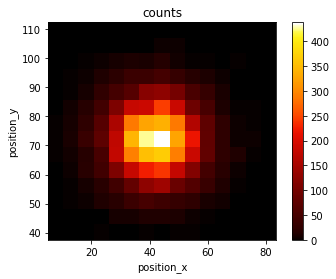

In [6]:
lc.render_2d(locdata, bin_size=5);

## Blinking statistics

To determine on- on off-times for teh observed blink events use the analysis class `BlinkStatistics`.

In [7]:
bs = lc.BlinkStatistics(memory=0, remove_heading_off_periods=False).compute(locdata)
bs

BlinkStatistics(memory=0, remove_heading_off_periods=False)

In [8]:
bs.results

{'on_periods': array([2, 1, 4, ..., 2, 3, 7]),
 'off_periods': array([24,  9, 23, ..., 31, 22,  1])}

When plotting the histogram an exponential distribution is fitted by default.

<AxesSubplot:title={'center':'Distribution of on_periods'}, xlabel='on_periods (frames)', ylabel='PDF'>

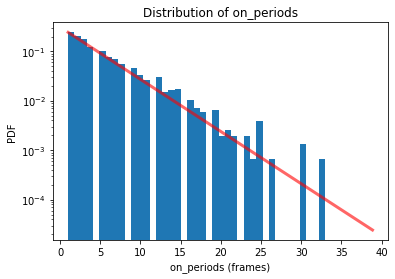

In [9]:
bs.hist(data_identifier='on_periods');

<AxesSubplot:title={'center':'Distribution of off_periods'}, xlabel='off_periods (frames)', ylabel='PDF'>

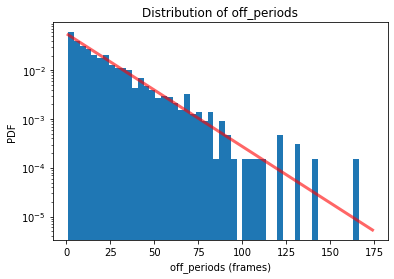

In [10]:
bs.hist(data_identifier='off_periods');

In [11]:
bs.distribution_statistics

{'on_periods': _DistributionFits(analysis_class=BlinkStatistics, distribution=expon_gen, data_identifier=on_periods),
 'off_periods': _DistributionFits(analysis_class=BlinkStatistics, distribution=expon_gen, data_identifier=off_periods)}

In [12]:
bs.distribution_statistics['on_periods'].parameter_dict()

{'on_periods_loc': 1.0, 'on_periods_scale': 4.112474437627812}

In [13]:
bs.distribution_statistics['off_periods'].parameter_dict()

{'off_periods_loc': 1.0, 'off_periods_scale': 18.776470588235295}

Due to the default setting for the scaling parameter loc the mean on_period is `on_periods_scale + on_periods_loc` in agreement with our input value.

## Geometric distribution

We can compare this with a geometric distribution that is estimated from the observed `mean=1/on_scale`.

In [14]:
on_periods_mean = bs.results['on_periods'].mean()
on_periods_mean.round(2)

5.11

In [15]:
off_periods_mean = bs.results['off_periods'].mean()
off_periods_mean.round(2)

19.78

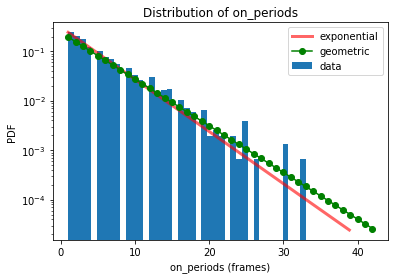

In [16]:
# test result
x = np.arange(stats.geom.ppf(0.01, 1/on_periods_mean), stats.geom.ppf(0.9999, 1/on_periods_mean))
y = stats.geom.pmf(x, 1/on_periods_mean)
fig, ax = plt.subplots()
bs.hist(data_identifier='on_periods', fit=False, label='data')
bs.distribution_statistics['on_periods'].plot(label='exponential')
ax.plot(x, y, '-go', label='geometric')
ax.set_yscale('log')
ax.legend(loc='best')
plt.show()